# 인코딩 / 디코딩 함수


In [1]:
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


In [2]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


# 필요한 라이브러리 불러오기

In [3]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

import numpy as np
import tensorflow as tf
import os

1.3.3
0.5.2
3.8.3


# 1. 데이터 준비와 확인

In [4]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 로더 구성

데이터 로더의 역할 :
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴



In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    #     # 데이터의 중복제거
    #     train_data = train_data.drop_duplicates()
    #     test_data = test_data.drop_duplicates()
    #     # 데이터의 NAN 결측치 제거
    #     train_data = train_data.dropna()
    #     test_data = test_data.dropna()
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        # 불용어 제거
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    # 토큰화
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        # 불용어 제거
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 1만개 단어사전인데, PAD, BOS, UNK, UNUSED가 추가된다.
    
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # PAD, BOS, UNK, UNUSED 추가
    word_to_index = {word:index for index, word in enumerate(vocab)} # 5. 사전  word_to_index 구성
        
    
    # 사전 word to index 구성
    def wordlist_to_indexlist(wordlist):
        # <BOS>의 인덱스를  문장 앞 추가
        # 단어사전에 있으면 index 변환, 없으면(else) '<UNK>' 의 인덱스로 된 리스트를 반환.
        return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    # 6. 텍스트 스트링을 사전 인덱스 스트링을 변환            
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

### 코드분석

- collections 의 counter
기본 자료구조인 사전(dictionary)를 확장
데이터의 갯수를 세어주는 코드

- counter.most_common()
데이터가 많은 순으로 정렬된 배열을 리턴합니다.

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포 확인
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 활용해서 패딩 추가

In [8]:
total_data = X_train + X_test

total_data_len = list(map(len, total_data))


In [9]:
print('---total_data---')
print('문장 길이 평균 : ', np.mean(total_data_len))
print('문장 길이 분산 : ', np.std(total_data_len))
print('문장 길이 최대 : ', np.max(total_data_len))
print('문장 길이 최소 : ', np.min(total_data_len))

---total_data---
문장 길이 평균 :  16.96940191154864
문장 길이 분산 :  12.843571191092
문장 길이 최대 :  117
문장 길이 최소 :  1


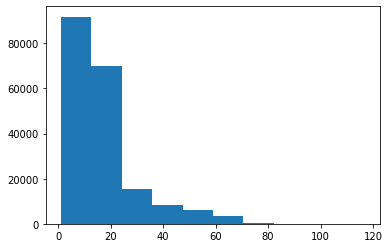

In [10]:
import matplotlib.pyplot as plt

plt.hist(total_data_len)
plt.show()

In [11]:
# 최대 길이를 (평균 + 2.2*표준편차)로 한다면,  
length = (np.mean(total_data_len) + 2.2* np.std(total_data_len))
maxlen = int(length)

In [12]:
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. '\
      .format(100 * np.sum(total_data_len<length) / len(total_data_len)))

전체 문장의 94.34%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(146182, 45) (49157, 45)


# 4. Validation set 구성 및 Modeling

1. 노드에 있던 LSTM 모델
2. CNN 모델

### validation set 구성



In [14]:
# validation set 20000건 분리
X_val = X_train[:20000]
y_val = y_train[:20000]

# validation set을 제외한 나머지 126182건
partial_X_train = X_train[20000:]
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 45)
(126182,)


In [15]:
import keras
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [16]:
# model_LSTM 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(keras.layers.LSTM(20))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_LSTM.add(keras.layers.Dense(8, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 20)                22160     
_________________________________________________________________
dense (Dense)                (None, 8)                 168       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,582,337
Trainable params: 2,582,337
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          28688     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# 5. 모델 훈련 개시 및 시각화

### 1. lstm

In [18]:
model_LSTM.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

epochs=10 # 훈련결과 보고 바꿔보기

history_lstm = model_LSTM.fit(partial_X_train,
                  partial_y_train,
                  epochs=epochs,
                  batch_size=512,
                  validation_data=(X_val, y_val), 
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 6s 9ms/step - loss: 0.4183 - accuracy: 0.8132 - val_loss: 0.3475 - val_accuracy: 0.8497
Epoch 2/10
247/247 [==============================] - 2s 7ms/step - loss: 0.3180 - accuracy: 0.8649 - val_loss: 0.3363 - val_accuracy: 0.8554
Epoch 3/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2828 - accuracy: 0.8813 - val_loss: 0.3327 - val_accuracy: 0.8562
Epoch 4/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2509 - accuracy: 0.8960 - val_loss: 0.3351 - val_accuracy: 0.8589
Epoch 5/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2228 - accuracy: 0.9097 - val_loss: 0.3453 - val_accuracy: 0.8593
Epoch 6/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2013 - accuracy: 0.9192 - val_loss: 0.3728 - val_accuracy: 0.8545
Epoch 7/10
247/247 [==============================] - 2s 7ms/step - loss: 0.1798 - accuracy: 0.9298 - val_loss: 0.3931 - val_accuracy: 0.8511
Epoch 

In [19]:
# 테스트셋으로 평가

lstm_results = model_LSTM.evaluate(X_test, y_test, verbose=2)

print(lstm_results)

1537/1537 - 3s - loss: 0.4712 - accuracy: 0.8473
[0.4712178111076355, 0.8473259210586548]


### lstm 시각화

In [20]:
history_lstm_dict = history_lstm.history
print(history_lstm_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
acc = history_lstm_dict['accuracy']
val_acc = history_lstm_dict['val_accuracy']
loss = history_lstm_dict['loss']
val_loss = history_lstm_dict['val_loss']

epochs = range(1, len(acc) + 1)

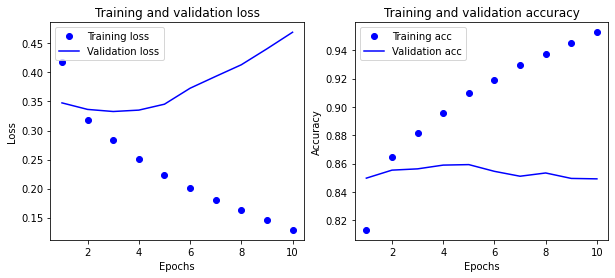

In [22]:
plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2. cnn

In [23]:
model_CNN.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

epochs=10 # 훈련결과 보고 바꿔보기

history_cnn = model_CNN.fit(partial_X_train,
                  partial_y_train,
                  epochs=epochs,
                  batch_size=512,
                  validation_data=(X_val, y_val), 
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 4s 9ms/step - loss: 0.5413 - accuracy: 0.7010 - val_loss: 0.4573 - val_accuracy: 0.7696
Epoch 2/10
247/247 [==============================] - 2s 7ms/step - loss: 0.4201 - accuracy: 0.7935 - val_loss: 0.4487 - val_accuracy: 0.7737
Epoch 3/10
247/247 [==============================] - 2s 7ms/step - loss: 0.3629 - accuracy: 0.8250 - val_loss: 0.4675 - val_accuracy: 0.7652
Epoch 4/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2903 - accuracy: 0.8630 - val_loss: 0.5111 - val_accuracy: 0.7624
Epoch 5/10
247/247 [==============================] - 2s 7ms/step - loss: 0.2236 - accuracy: 0.8930 - val_loss: 0.5883 - val_accuracy: 0.7538
Epoch 6/10
247/247 [==============================] - 2s 7ms/step - loss: 0.1809 - accuracy: 0.9104 - val_loss: 0.6773 - val_accuracy: 0.7500
Epoch 7/10
247/247 [==============================] - 2s 7ms/step - loss: 0.1549 - accuracy: 0.9203 - val_loss: 0.7688 - val_accuracy: 0.7487
Epoch 

In [24]:
# 테스트셋으로 평가

cnn_results = model_CNN.evaluate(X_test, y_test, verbose=2)

print(cnn_results)

1537/1537 - 3s - loss: 0.9706 - accuracy: 0.7456
[0.9706434607505798, 0.7456110119819641]


### cnn 시각화

In [25]:
history_cnn_dict = history_cnn.history
print(history_cnn_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
acc = history_cnn_dict['accuracy']
val_acc = history_cnn_dict['val_accuracy']
loss = history_cnn_dict['loss']
val_loss = history_cnn_dict['val_loss']

epochs = range(1, len(acc) + 1)

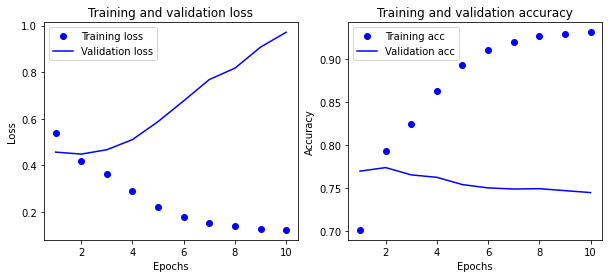

In [27]:
plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

cnn 모델은 학습이 된건가? ㅎ_ㅎ acc loss 수치는 괜찮은거 같은데 왜 epoch마다 업데이트가 안되었니

In [28]:
print(lstm_results)
print(cnn_results)

[0.4712178111076355, 0.8473259210586548]
[0.9706434607505798, 0.7456110119819641]


# 6. 학습된 Embedding 레이어 분석 

학습된 lstm모델의 embedding 레이어를 분석해보았습니다.

In [29]:
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 256)


In [30]:
# 학습한 Embedding 파라미터를 파일에 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ex.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록한다 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['공부']
vector

array([-0.04217565,  0.02709974,  0.08548456, -0.0025989 , -0.00127447,
       -0.05441006,  0.06940414,  0.0394337 , -0.01441484,  0.03288127,
       -0.04423527, -0.05094121,  0.025768  ,  0.00591537,  0.01067466,
       -0.1054012 ,  0.01218356,  0.00406791,  0.02619375, -0.0060713 ,
       -0.08739371, -0.08559152,  0.08260231, -0.01098876, -0.01176621,
        0.02104817, -0.09641816,  0.03193166, -0.02932103, -0.07707547,
        0.01663093,  0.04657099, -0.06683973, -0.1249376 , -0.02983947,
        0.02493549, -0.00930329,  0.05503241, -0.02261068, -0.03910672,
        0.03649214,  0.02190821,  0.02412679,  0.03638781,  0.035801  ,
        0.06336644,  0.00178176, -0.19084884, -0.04135275, -0.13275844,
       -0.02050579, -0.02228265,  0.1750152 ,  0.1264985 , -0.07420102,
        0.08021517, -0.04082129, -0.05133   , -0.04231986,  0.04094657,
        0.0151191 ,  0.04397049, -0.03768059,  0.03842506,  0.09317244,
        0.02949879,  0.01109563, -0.03254161,  0.00336628, -0.05

In [32]:
word_vectors.similar_by_word('공부')

[('오유', 0.7222700119018555),
 ('무적', 0.7183214426040649),
 ('누리', 0.7181184887886047),
 ('출시', 0.7074424028396606),
 ('훼손', 0.7071419954299927),
 ('으으', 0.7007338404655457),
 ('잊혀질', 0.6958034038543701),
 ('듣보잡', 0.6955004334449768),
 ('구석', 0.6931321024894714),
 ('틴', 0.6882127523422241)]

공부 단어와 유사한 단어를 뽑아봤는데 학습이 잘 되어있지않음을 알 수 있습니다.

# 7. 한국어  Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec의 버전이, lms 노드의 버전과 달라 버전을 다운그레이드 해 줘야한다.
- 우선, 현재 gensim의 버전은 '4.1.2'
- 3.X.X 대로 낮춰줘야 오류가 없기 때문에 다운그레이드 해 주었습니다.

In [33]:
import gensim
gensim.__version__ 

'3.8.3'

In [34]:
!pip install --upgrade gensim==3.8.3 #[버전 다운그레이드 하는 코드]

In [35]:
!pip list | grep gensim

gensim                        3.8.3


In [36]:
import gensim
gensim.__version__ 

'3.8.3'

https://github.com/Kyubyong/wordvectors
여기 링크에서 pretrained된 한국어 Word2Vec 모델 중, ko.bin으로 된 파일을 다운받아줍니다.

In [37]:
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['공부']
vector 

/tmp/ipykernel_1203/1316809659.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['공부']


array([-5.3616351e-01,  1.5259813e+00,  2.2119961e+00, -2.3817079e+00,
       -9.5158440e-01,  8.9626066e-02, -5.2998513e-01,  4.0423288e+00,
        8.7127805e-01, -3.5876250e-01, -1.3750417e+00, -1.4647077e-01,
        2.0774379e+00, -2.4233997e+00, -8.8370997e-01,  8.4815770e-01,
        1.5400079e-01, -3.0943182e+00,  2.2277091e+00,  1.9544889e-01,
        4.3067582e-02, -9.6882504e-01,  9.8499590e-01, -1.1479219e+00,
        4.0785190e-01, -3.1964517e+00, -6.1084163e-01, -1.3357921e+00,
       -1.1660659e+00,  1.5545406e+00,  7.2543573e-01, -6.1742734e-02,
        3.9433134e-01, -1.2887758e+00,  2.5079210e+00,  8.8275224e-01,
       -1.2752281e+00, -3.1425264e-01, -1.3679795e+00, -2.3178179e+00,
       -2.7225506e-01, -2.3925257e+00,  2.6611121e+00, -6.6377121e-01,
       -4.3277806e-01,  6.4304197e-01,  3.3505702e+00, -2.4624436e+00,
        1.1853255e+00, -4.4038731e-01,  1.5087553e+00, -1.0823973e+00,
        7.1410012e-01, -2.9199111e-01,  4.8847135e-02, -6.5211141e-01,
      

In [38]:
word2vec.similar_by_word("공부")

/tmp/ipykernel_1203/3761813252.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("공부")


[('가르치', 0.6655912399291992),
 ('중퇴', 0.6448310613632202),
 ('수학', 0.6283489465713501),
 ('졸업', 0.5976732969284058),
 ('한학', 0.5947862267494202),
 ('수료', 0.5928074717521667),
 ('영문학', 0.5868287086486816),
 ('전공', 0.5848740339279175),
 ('배우', 0.5693216919898987),
 ('강론', 0.5641564726829529)]

아까와 달리 유사한 단어들이 잘 나오는 것을 알 수 있습니다.

### 모델의 임베딩 레이어를 Word2Vec으로 교체시켜 다시 학습시키기

In [39]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_1203/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_1203/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


# 8. 임베딩 레이어를 word2Vec으로 교체시켜서 새롭게 학습시키기

In [41]:
from tensorflow.keras.initializers import Constant
model= keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                word_vector_dim, 
                                embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                input_length=maxlen, 
                                trainable=True))   # trainable을 True로 주면 Fine-tuningmodel.add(keras.layers.LSTM(20))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.LSTM(20))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 45, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                17680     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,017,857
Trainable params: 2,017,857
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 4s 9ms/step - loss: 0.4833 - accuracy: 0.7631 - val_loss: 0.3715 - val_accuracy: 0.8394
Epoch 2/20
247/247 [==============================] - 2s 7ms/step - loss: 0.3441 - accuracy: 0.8512 - val_loss: 0.3435 - val_accuracy: 0.8519
Epoch 3/20
247/247 [==============================] - 2s 7ms/step - loss: 0.3052 - accuracy: 0.8717 - val_loss: 0.3347 - val_accuracy: 0.8590
Epoch 4/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2813 - accuracy: 0.8827 - val_loss: 0.3335 - val_accuracy: 0.8594
Epoch 5/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2634 - accuracy: 0.8912 - val_loss: 0.3479 - val_accuracy: 0.8544
Epoch 6/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2464 - accuracy: 0.9009 - val_loss: 0.3407 - val_accuracy: 0.8608
Epoch 7/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2302 - accuracy: 0.9080 - val_loss: 0.3494 - val_accuracy: 0.8610
Epoch 

In [43]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6589 - accuracy: 0.8387
[0.6589290499687195, 0.8386801481246948]


### 시각화

In [44]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [45]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

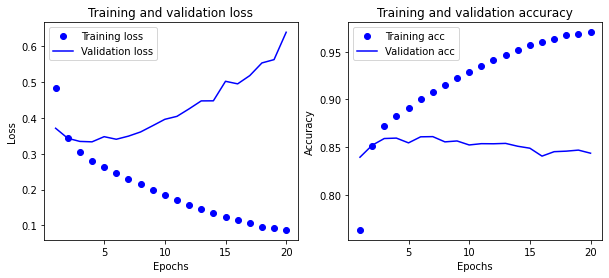

In [46]:
plt.figure(figsize=(10, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # "b"는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 회고

1. 아래 코드 블록 두개를 보면, 옵션값을 다르게 줌으로써 토큰화된 문장을 디코딩하면 결과가 다르다. 정확히 어떤 부분이 달라지는지, 제대로 알아보고싶다.

    # 데이터의 중복제거
    train_data = train_data.drop_duplicates()
    test_data = test_data.drop_duplicates()
    # 데이터의 NAN 결측치 제거
    train_data = train_data.dropna()
    test_data = test_data.dropna()

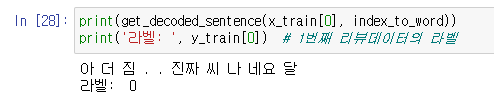

    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

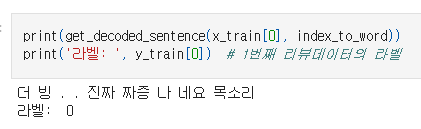

2. 같은데이터로 padding을 pre로 처리하는것과 post에 붙이는것 차이가 성능이 얼마나 차이나는지 확인해보고싶었는데, 이를 직접 해보지 못한 점이 아쉽다. 다시 공부할 때는 꼭 체크해보려한다.
3. gensim에서 계속 오류가 났는데 주피터노트북에서 pip install gensim=3.8.3을 돌려도 기존의 4.1.2가 나왔다. 결국 lms에서 직접 gensim을 삭제하고 다시 설치한 후, lms를 다시 로그인까지 하고나니 설치가 됐다.
4. 네이버 리뷰의 raw데이터가 ㅋㅋㅋ과 같은 단어가 많아서 이런 부분을 전처리해서 없애주고싶다.